<center>
<img src="https://raw.githubusercontent.com/hse-econ-data-science/andan2024/main/hw/images/bogdanoff_cover.jpeg" height="150">

# Андан на экономе: домашнее задание 2
</center>


> [He bought? Dump it. He sold? Pump it.](https://www.youtube.com/watch?v=fDpYZU5FAVU)  <br>

$\qquad$ $\qquad$ $\qquad$ $\qquad$  📉 📉 📉**Bogdanoff**


In [2]:
import numpy as np
import pandas as pd

import scipy.stats as sts
import matplotlib.pyplot as plt
import seaborn as sns

#  Портфельная теория Марковица

В этом задании мы будем работать с данными по ценным бумагам. Мы немного поанализируем их и попробуем собрать оптимальный портфель.

- в таблице `stocks.csv` содержится информация об акциях нескольких компаний с $01.01.2014$ по $31.12.2023$ по дням.
- таблице `exchange_rates.csv` содержится информация о курсах валют _USD-RUB_, _EUR-RUB_ и _HKD-RUB_ за тот же период.

Подгрузим данные и посмотрим на них.

In [7]:
df_stocks = pd.read_csv('https://raw.githubusercontent.com/hse-econ-data-science/andan2024/main/hw/data/stocks.csv')
print(df_stocks.shape)
df_stocks.head()

(17572, 8)


,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Тикер
0,29.12.2023,"192,53","193,90","194,40","191,73","42,67M","-0,54%",AAPL
1,28.12.2023,"193,58","194,14","194,66","193,17","33,83M","0,22%",AAPL
2,27.12.2023,"193,15","192,49","193,50","191,09","47,90M","0,05%",AAPL
3,26.12.2023,"193,05","193,61","193,89","192,83","28,81M","-0,28%",AAPL
4,22.12.2023,"193,60","195,18","195,41","192,97","37,15M","-0,55%",AAPL


In [8]:
df_rates = pd.read_csv('https://raw.githubusercontent.com/hse-econ-data-science/andan2024/main/hw/data/exchange_rates.csv')
print(df_rates.shape)
df_rates.head()

(3652, 4)


,Дата,EUR_RUB,USD_RUB,HKD_RUB
0,01.01.2014,"45,189","32,855","4,237"
1,02.01.2014,"45,254","33,1","4,269"
2,03.01.2014,"45,114","33,2","4,282"
3,04.01.2014,"45,125","33,248","4,288"
4,05.01.2014,"45,228","33,255","4,289"


## 1 Причешем данные

Часто при загрузке данных из каких-либо источников, особенно если они разные, у вас будет возникать необходимость в их форматировании. Поэтому в этой части потренируемся корректировать переменные для последующей работы с ними.


__а) [2 балла]__ В колонке `'Дата'` лежат дни, в которые осуществлялась торговля акциями. Превратите её в формат `datetime` в обеих таблицах.

In [9]:
df_stocks['Дата'] = pd.to_datetime(df_stocks['Дата'], format='%d.%m.%Y')
df_rates['Дата'] = pd.to_datetime(df_rates['Дата'], format='%d.%m.%Y')

__б) [5 баллов]__ Для продолжения работы необходимо перевести столбцы в числовой формат, однако они содержат некорректные символы, которые не позволят сделать это напрямую.

Допишите функцию, которая примет на вход тип данных `string` и:

- Уберет лишнюю точку, разделяющую тысячные разряды в числах (например, $2.024,01 \rightarrow 2024,01$)
- Заменит символ запятой, отделяющий десятичный разряд, на точку (например, $2024,01 \rightarrow 2024.01$)
- Уберет символы `%`, `'B'` (млрд), `'M'` (млн) и `'K'` (тыс)
- Затем изменит тип данных с `string` на `float`
- И домножит на $10^9$, если в исходном значении содержалась `'B'`, на $10^6$, если `'M'`, или на $10^3$, если `'K'`.

In [10]:

def correct_values(value):
    corrected_value = str(value).replace('.', '').replace(',', '.').replace('%', '')
    if 'B' in corrected_value:
        corrected_value = corrected_value.replace('B', '')
        corrected_value = float(corrected_value) * 10**9
    elif 'M' in corrected_value:
        corrected_value = corrected_value.replace('M', '')
        corrected_value = float(corrected_value) * 10**6
    elif 'K' in corrected_value:
        corrected_value = corrected_value.replace('K', '')
        corrected_value = float(corrected_value) * 10**3
    return float(corrected_value)  


Примените данную функцию к столбцам `'Цена', 'Откр.', 'Макс.', 'Мин.', 'Объём', 'Изм. %'` таблицы `df_stocks` и к столбцам `'EUR_RUB', 'USD_RUB', 'HKD_RUB'` таблицы `df_rates`.

__Hint:__ Для этого можно использовать метод `map` библиотеки `pandas`. Важно также указать параметр `na_action='ignore'`, чтобы пустые значения не передавались в функцию `correct_values`, [(ссылка на документацию).](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.map.html)

In [11]:

for column in ['Цена', 'Откр.', 'Макс.', 'Мин.', 'Объём', 'Изм. %']:
    df_stocks[column] = df_stocks[column].map(correct_values, na_action='ignore')

for column in ['EUR_RUB', 'USD_RUB', 'HKD_RUB']:
    df_rates[column] = df_rates[column].map(correct_values, na_action='ignore')
df_stocks.head()

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Тикер
0,2023-12-29,192.53,193.90,194.40,191.73,42670000.0,-0.54,AAPL
1,2023-12-28,193.58,194.14,194.66,193.17,33830000.0,0.22,AAPL
2,2023-12-27,193.15,192.49,193.50,191.09,47900000.0,0.05,AAPL
3,2023-12-26,193.05,193.61,193.89,192.83,28810000.0,-0.28,AAPL
4,2023-12-22,193.60,195.18,195.41,192.97,37150000.0,-0.55,AAPL


__в) [5 баллов]__ Поскольку акции компаний торгуются на разных биржах, цены также указаны в различных валютах.
Давайте приведем все к рублям, используя таблицу `df_rates`. Для этого важно знать, что данные по тикерам:

- `'AAPL'` и `'MSFT'` собраны в долларах `USD`
- `'MBGn'` и `'BMWG'` $-$ в евро `EUR`
- `'Tencent'` $-$ в Гонконгских долларах `HKD`
- по остальным $-$ в `RUB`

Давайте сначала объединим таблицы, выполнив операцию `left join` таблицы `df_stocks` с `df_rates` по столбцу `'Дата'`. Для этого будем использовать метод `merge`, [(ссылка на документацию).](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html)

In [12]:
df_merged = pd.merge(df_stocks, df_rates, on='Дата', how='left')


df_merged.head()

,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Тикер,EUR_RUB,USD_RUB,HKD_RUB
0,2023-12-29,192.53,193.90,194.40,191.73,42670000.0,-0.54,AAPL,98.596,90.36,11.429
1,2023-12-28,193.58,194.14,194.66,193.17,33830000.0,0.22,AAPL,97.919,89.36,11.325
2,2023-12-27,193.15,192.49,193.50,191.09,47900000.0,0.05,AAPL,101.779,91.27,11.731
3,2023-12-26,193.05,193.61,193.89,192.83,28810000.0,-0.28,AAPL,101.455,91.66,11.734
4,2023-12-22,193.60,195.18,195.41,192.97,37150000.0,-0.55,AAPL,101.467,92.00,11.791


 Затем преобразуем столбцы `'Цена', 'Откр.', 'Макс.', 'Мин.'`, умножив их на соответствующий данной акции курс.

In [13]:

stocks_currency_dict = {
    "AAPL": "USD_RUB",
    "MSFT": "USD_RUB",
    "MBGn": "EUR_RUB",
    "BMWG": "EUR_RUB",
    "Tencent": "HKD_RUB",
}

for ticker, curr_pair in stocks_currency_dict.items():
    for column in ['Цена', 'Откр.', 'Макс.', 'Мин.']:
        df_merged.loc[df_merged['Тикер'] == ticker, column] *= df_merged[curr_pair]
del df_merged['EUR_RUB']
del df_merged['USD_RUB']
del df_merged['HKD_RUB']
df_merged


,Дата,Цена,Откр.,Макс.,Мин.,Объём,Изм. %,Тикер
0,2023-12-29,17397.01080,17520.80400,17565.98400,17324.72280,42670000.0,-0.54,AAPL
1,2023-12-28,17298.30880,17348.35040,17394.81760,17261.67120,33830000.0,0.22,AAPL
2,2023-12-27,17628.80050,17568.56230,17660.74500,17440.78430,47900000.0,0.05,AAPL
3,2023-12-26,17694.96300,17746.29260,17771.95740,17674.79780,28810000.0,-0.28,AAPL
4,2023-12-22,17811.20000,17956.56000,17977.72000,17753.24000,37150000.0,-0.55,AAPL
...,...,...,...,...,...,...,...,...
17567,2014-01-08,416.51786,418.99968,419.81269,415.10579,18870000.0,1.52,Tencent
17568,2014-01-07,409.79112,416.03116,416.03116,408.80810,15020000.0,-0.32,Tencent
17569,2014-01-06,411.98177,410.65404,418.53476,407.31330,20380000.0,0.32,Tencent
17570,2014-01-03,410.55816,415.52528,419.29344,409.57330,18600000.0,-2.08,Tencent


Наконец, мы закончили с первичными преобразованиями и можем приступать к дальнейшему анализу.

## 2 Начало работы с данными

__а) [2 балла]__ Посмотрите наличие пропусков в данных таблицы `df_merged`. Информация по каким тикерам и за какой период отсутствует? Удалите строки с пропущенными данными.

In [14]:
empty_columns = df_merged.isnull().any(axis = 0) #column id
empty_rows = df_merged.isnull().any(axis = 1) #row id

tickers = df_merged.loc[empty_rows]['Тикер'].unique()
dates = df_merged.loc[empty_rows]['Дата'].unique()

print("Тикеры:")
for ticker in tickers:
    print(ticker)

print("\nДаты:")
for date in dates:
    print(date.strftime('%Y-%m-%d'))
    
df_merged = df_merged.dropna()


Тикеры:
AAPL
BMWG
MBGn
Tencent

Даты:
2016-02-27
2022-11-21
2022-05-03
2022-05-02
2022-05-04
2022-04-25
2015-01-17


__б) [2 балла]__ Какое количество уникальных тикеров содержится в таблице `df_stocks`?

In [15]:
unique_ticker = df_merged['Тикер'].unique()
len(unique_ticker)

7

__в) [2 балла]__  Для каких акций и в какой временной период была зафиксирована наибольшая разность между значениями `'Макс.'` и `'Мин.'` в рублях?

In [16]:
#Без использования копии выдает SettingWithCopyWarning 
df_merged_copy = df_merged.copy()
df_merged_copy['Разность'] = df_merged_copy['Макс.'] - df_merged_copy['Мин.']

max_diff = df_merged_copy.loc[df_merged_copy['Разность'].idxmax()]
print('Тикер:', max_diff['Тикер'])
print('Дата:', max_diff['Дата'].strftime('%Y-%m-%d'))
print('Разница:', max_diff['Разность'].round(0))


Тикер: MSFT
Дата: 2023-07-18
Разница: 2237.0


__г) [2 балла]__  В какие периоды было продано/куплено акций на наибольшую сумму рублей. Какие это были акции?

__Hint__: Объем — это количество проданных/купленных акций

In [17]:
df_merged_copy['объем в руб'] = df_merged_copy['Цена'] * df_merged_copy['Объём']
max_vol = df_merged_copy.loc[df_merged_copy['объем в руб'].idxmax()]

print('Тикер:', max_vol['Тикер'])
print('Дата:', max_vol['Дата'].strftime('%Y-%m-%d'))
print('объем:', max_vol['объем в руб'].round(0))

Тикер: AAPL
Дата: 2020-08-24
объем: 3249826226976.0


__д) [5 баллов]__  В столбике `'Изм. %'` лежат изменения стоимости ценных бумаг в процентах. При этом для каждой бумаги валюта своя.

Найдите 5 дат, в которые наблюдались наибольшие средние процентные изменения стоимости акций в абсолютном выражении.

__Hint:__ От изменения акций надо взять модуль, а затем посчитать среднее по тикерам для каждой даты.

In [18]:
unique_dates = df_merged_copy['Дата'].unique()
average_change = {}

for date in unique_dates:
    date_rows = df_merged_copy[df_merged_copy['Дата'] == date]
    average_change[date] = abs(date_rows['Изм. %']).mean().round(2)

    
    
sorted_average_changes = sorted(average_change.items(), key = lambda x: x[1], reverse = True)

for i in range(5):
    print(sorted_average_changes[i][0].strftime('%Y-%m-%d'), sorted_average_changes[i][1])
    
    

2022-02-24 13.08
2016-02-29 11.84
2020-03-24 10.8
2020-03-12 10.62
2022-02-21 9.13


__е) [2 балла]__ Сохраните ответ в переменную `top_5_diff` в виде таблички:

| Дата     | Изм. % |
|----------|--------|
| 01/01/01 |   1   |
|    ...   |  ...  |
| 03/01/01 |   3   |

In [19]:
top_5_diff = pd.DataFrame(sorted_average_changes, columns = ['Дата', 'Изм. %']).head()
top_5_diff

,Дата,Изм. %
0,2022-02-24,13.08
1,2016-02-29,11.84
2,2020-03-24,10.80
3,2020-03-12,10.62
4,2022-02-21,9.13


__ё) [5 баллов]__ Далее мы будем работать только со средними ценами, поэтому имеет смысл перевести таблицу из длинного формата в широкий

Было:

| Дата     | Цена | Тикер |
|----------|------|-------|
| 01/01/01 |  10  |   A   |
| 02/01/01 |  20  |   A   |
| 03/01/01 |  30  |   A   |
|   ...    | ...  |  ...  |
| 01/01/01 |  15  |   B   |
| 02/01/01 |  30  |   B   |
| 03/01/01 |  60  |   B   |
|   ...    | ...  |  ...  |

Станет:

| Дата     | Цена A | Цена B | ... |
|----------|--------|--------|-----|
| 01/01/14 |   10   |   15   | ... |
| 02/01/14 |   20   |   30   | ... |
| 03/01/14 |   30   |   60   | ... |
|   ...    |  ...   |  ...   | ... |


Это можно сделать по-разному, например, с помощью `pivot_table` ([ссылка](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.pivot_table.html) на документацию)

In [20]:
df = df_merged.pivot_table(index ='Дата', columns = 'Тикер', values = 'Цена')
df.columns = [f'Цена {ticker}' for ticker in df.columns]
df.head()


,Цена AAPL,Цена BMWG,Цена GAZP,Цена MBGn,Цена MSFT,Цена Tencent,Цена VTBR
Дата,,,,,,,
2014-01-02,653.72500,3780.51916,NaN,2789.90910,1229.99600,418.02048,NaN
2014-01-03,641.42400,3788.67372,NaN,2784.88722,1225.41200,410.55816,NaN
2014-01-06,645.27030,3756.04441,135.47,2785.23886,1199.87730,411.98177,0.04846
2014-01-07,639.27060,3770.02665,NaN,2815.67520,1206.62740,409.79112,NaN
2014-01-08,643.96557,3803.54355,137.33,2801.87619,1186.40952,416.51786,0.04791


__ж) [5 баллов]__  Для всех тикеров из таблички `df` постройти картинки с динамикой цен во времени, а также нистограммы цен. Дайте ответы на вопросы:

- Распределение стоимости акций похоже на нормальное?
- Что происходило с финансовыми рынками в течение последних $10$ лет? Они росли? Они падали? Видно ли, что были кризисы?

__Ответ:__

распределения стоимостей акций компаний похожи на нормальные распределения, но очень отдаленно, все таки финансовые рынки имеют свойство расти на длительном промежутке времени.

В целом наблюдается рост фин рынков, но важно отметить ковидный кризис 2021-2022 года, который значительно обвалил акции всех компаний, а затем кризис после 24 февраля 2022, который обвалил акции рф компаний

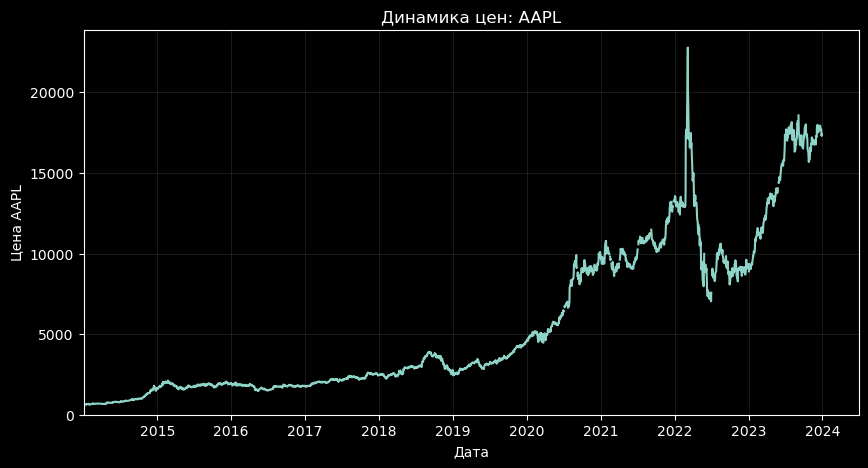

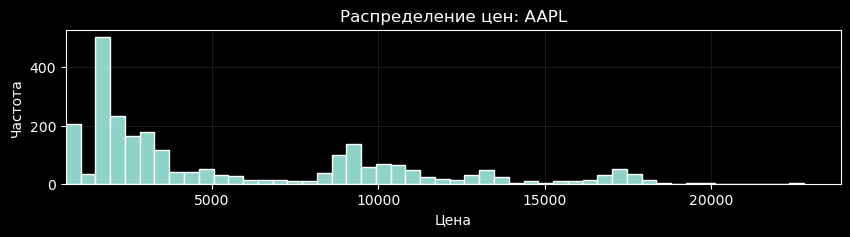

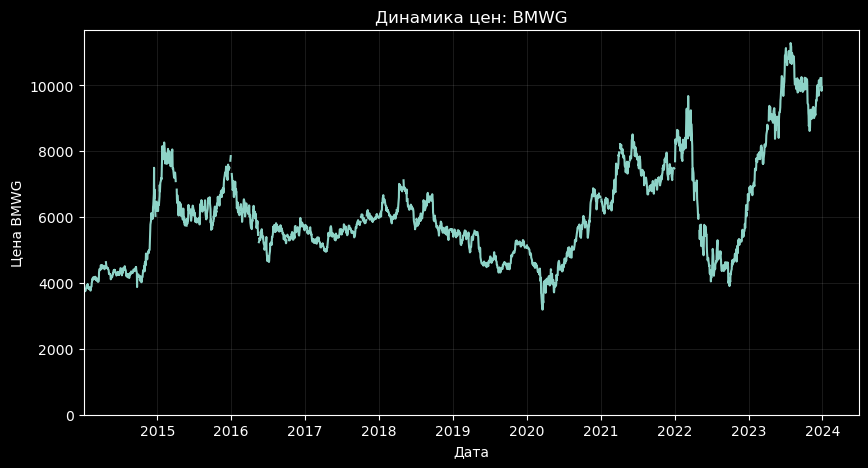

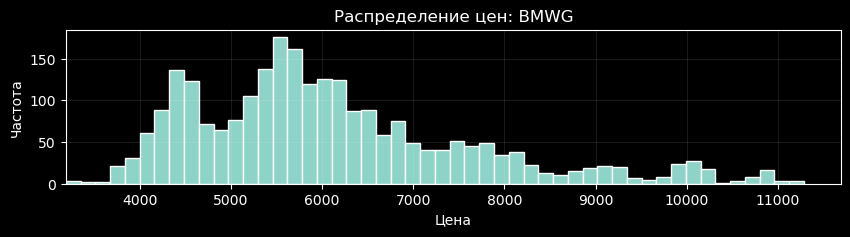

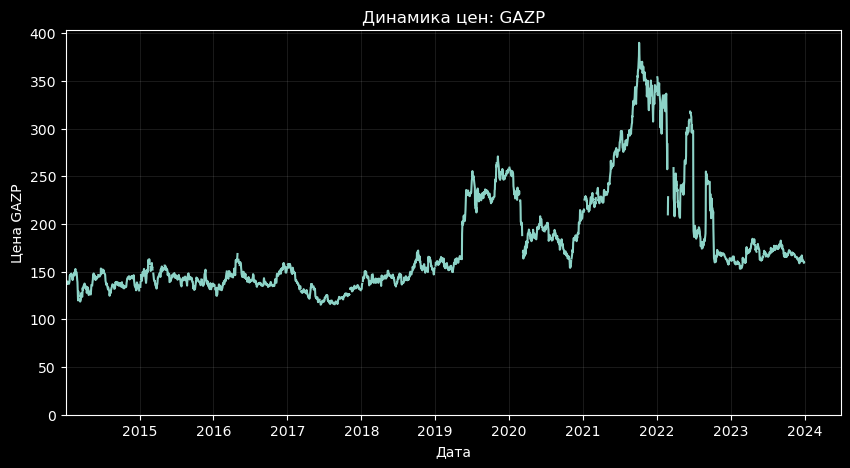

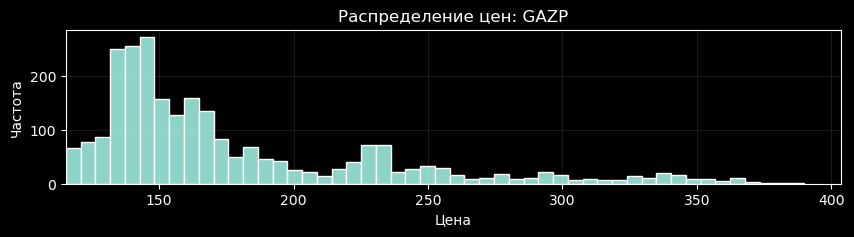

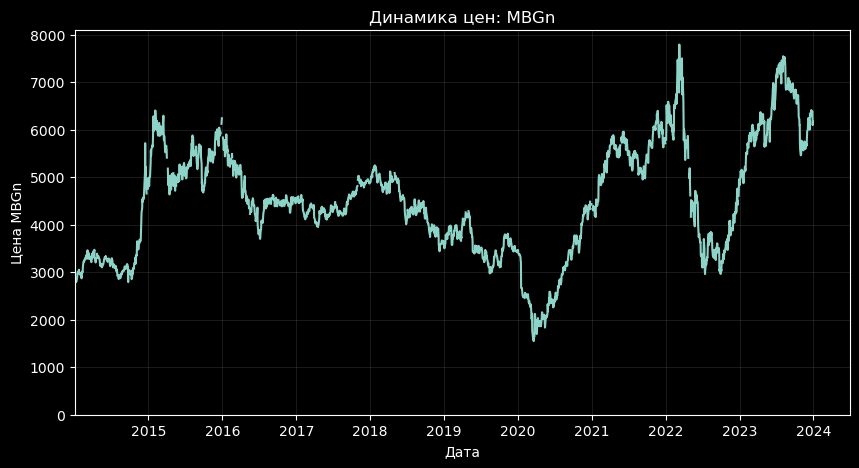

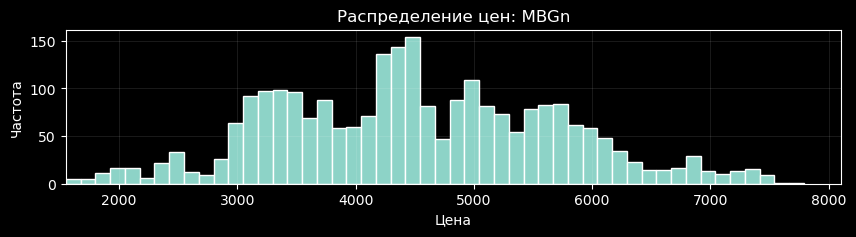

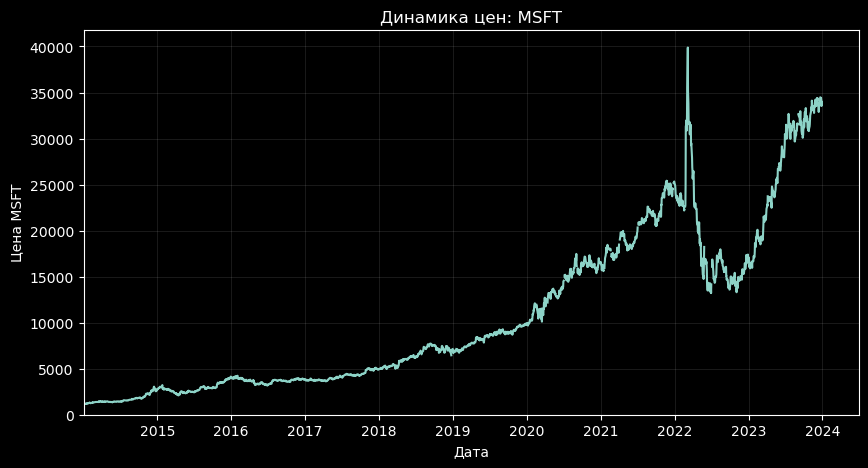

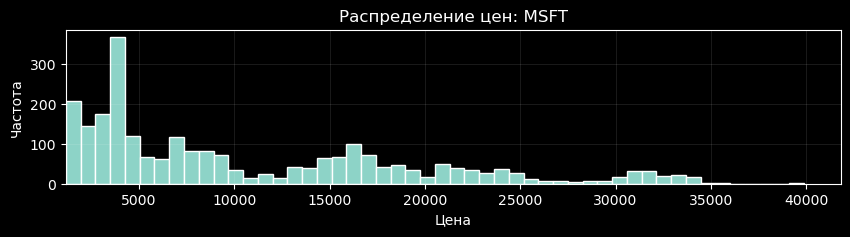

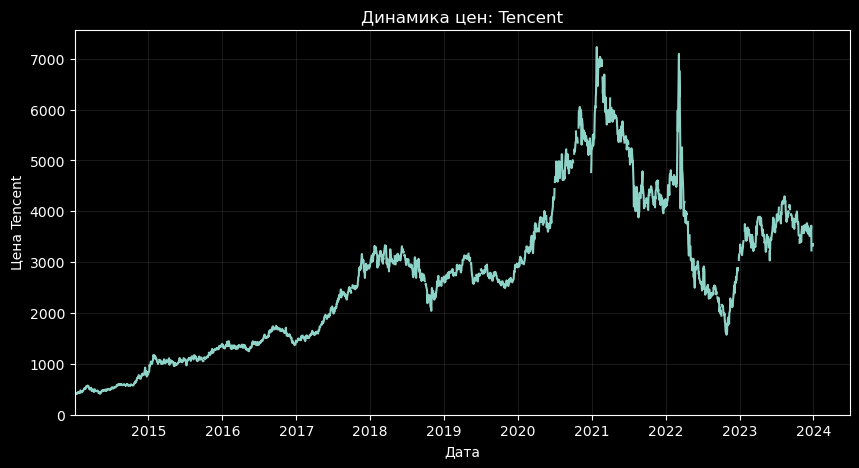

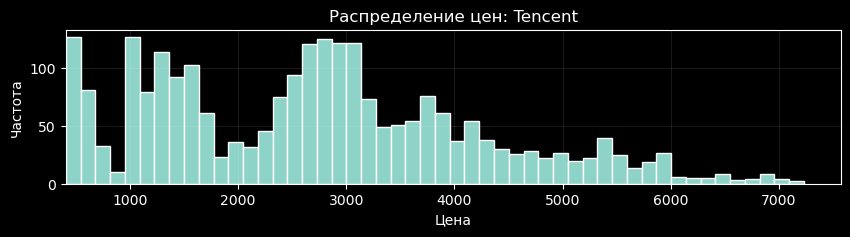

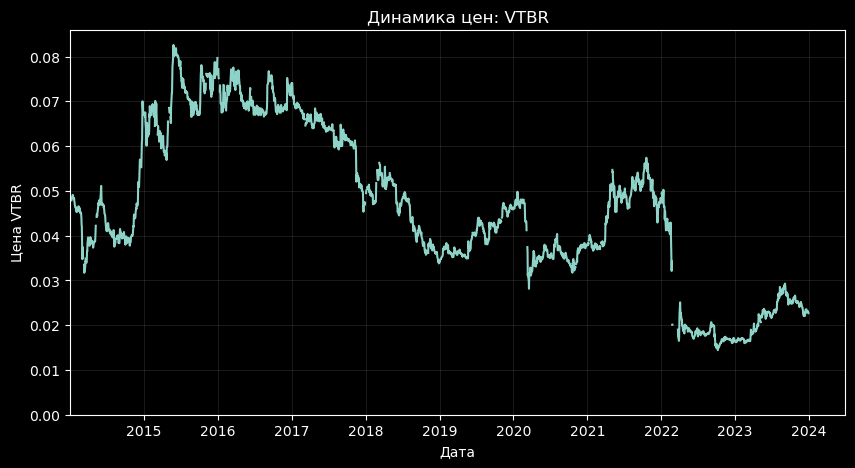

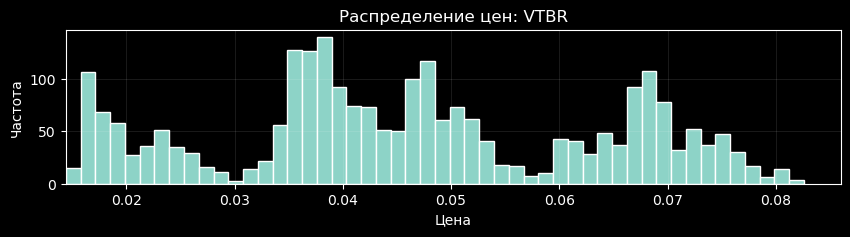

In [21]:
%matplotlib inline


for ticker in df.columns: 
    plt.style.use('dark_background')    
    plt.figure(figsize = (10, 5))
    plt.plot(df.index, df[ticker])  
    plt.title(f'Динамика цен: {ticker[5:]}')
    plt.grid(True, alpha = 0.1)
    plt.xlim(df.index.min())
    plt.ylim(0)
    plt.xlabel('Дата')
    plt.ylabel(ticker)  
    plt.show()
   
    plt.figure(figsize = (10, 2))
    plt.hist(df[ticker].dropna(), bins = 50, edgecolor = "white")
    #sns.histplot(df[ticker].dropna())
    plt.grid(True, alpha = 0.1)
    plt.title(f'Распределение цен: {ticker[5:]}')
    plt.xlim(df[ticker].dropna().min())
    plt.xlabel('Цена')
    plt.ylabel('Частота')
    plt.show()


Финансовые продукты описываются двумя характеристикам – __доходностью__ и __риском.__ Доходность – это процентное изменение стоимости за некоторый промежуток времени:

$$
R_t = \left( \frac{P_t}{P_{t-1}} - 1 \right) \cdot 100\%.
$$

Под риском обычно имеют в виду стандартное отклонение.


__з) [5 баллов]__  Рассчитайте процентное изменение цены акций в рублях ото дня ко дню для `df`. Полученную таблицу доходностей сохраните в переменную `df_pct_change`.

__Hint__: С этим поможет метод `pct_change()`, [(ссылка на документацию).](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pct_change.html)

In [22]:
df_pct_change = df.pct_change() * 100 

df_pct_change


,Цена AAPL,Цена BMWG,Цена GAZP,Цена MBGn,Цена MSFT,Цена Tencent,Цена VTBR
Дата,,,,,,,
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03,-1.881678,0.215699,NaN,-0.180002,-0.372684,-1.785157,NaN
2014-01-06,0.599650,-0.861233,NaN,0.012627,-2.083764,0.346750,NaN
2014-01-07,-0.929796,0.372260,0.000000,1.092773,0.562566,-0.531735,0.000000
2014-01-08,0.734426,0.889036,1.372998,-0.490078,-1.675569,1.641505,-1.134957
...,...,...,...,...,...,...,...
2023-12-25,0.000000,0.000000,-0.616941,0.000000,0.000000,0.000000,0.957563
2023-12-26,-0.652606,0.000000,-0.055869,0.000000,-0.348287,0.000000,-0.150895
2023-12-27,-0.373906,0.068282,-0.708075,0.020212,-0.582292,3.485307,-1.230570


__и) [5 баллов]__  Для всех тикеров из таблички `df_pct_change` постройти картинки с динамикой доходностей, гистограмму доходностей и ящики с усами. Ответьте на следующие вопроcы:

- Имеют ли доходности по акциям нормальное распределение?
- Видно ли по ящику с усами, что в данных довольно много выбросов?

__Ответ:__ Доходности действительно напоминают нормальные распределения, при чем для каждой акции из датасета. Ящики так же показывают большое количество выбросов. На графиках решил сделать отдельную картинку с ящиками без выбросов, чтобы повысить читаемость


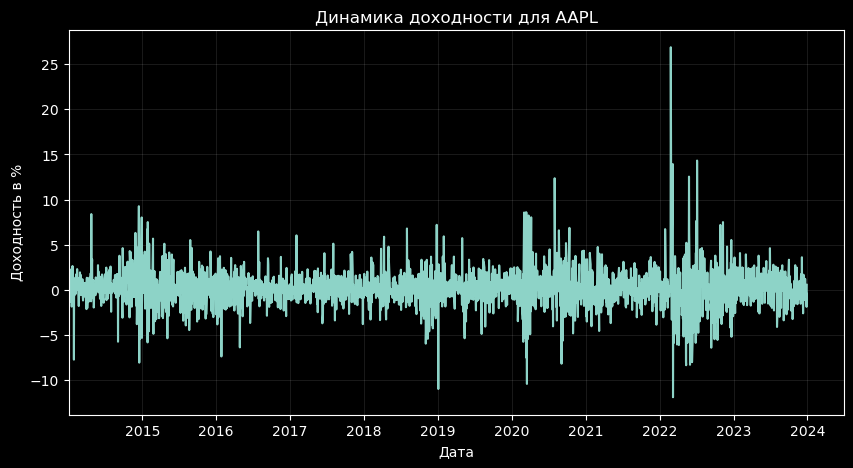

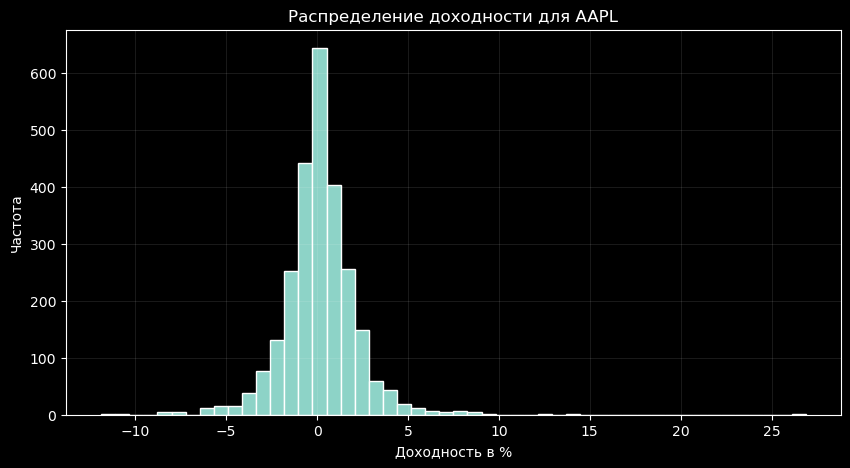

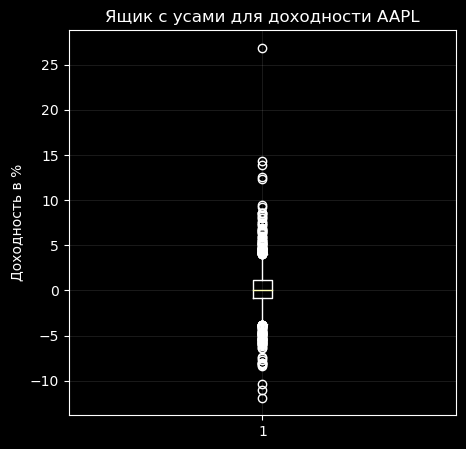

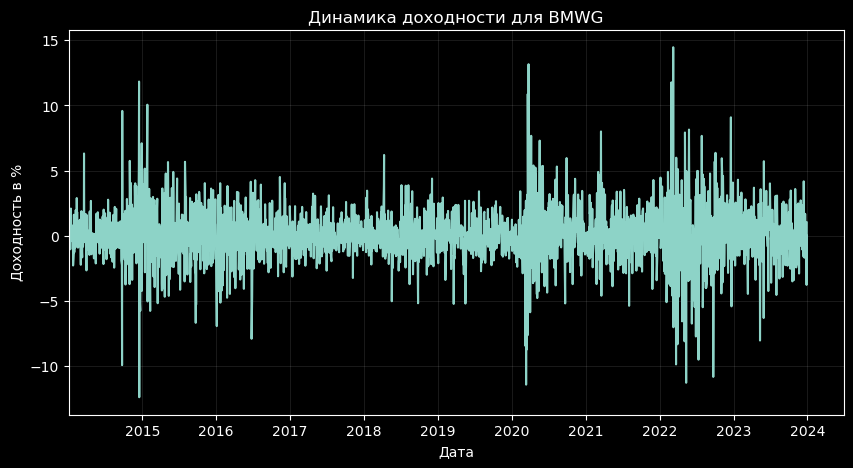

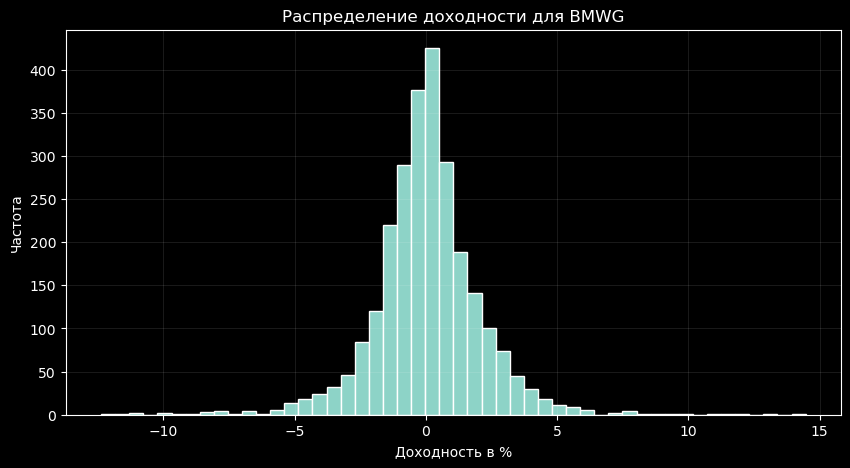

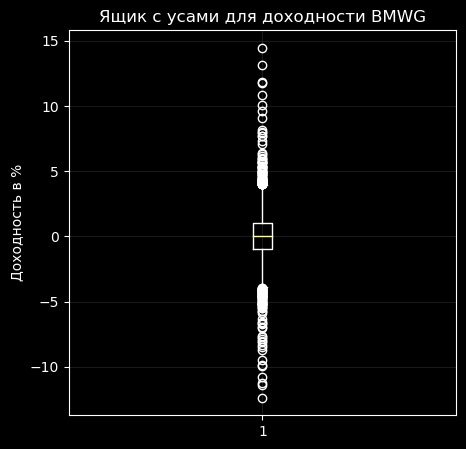

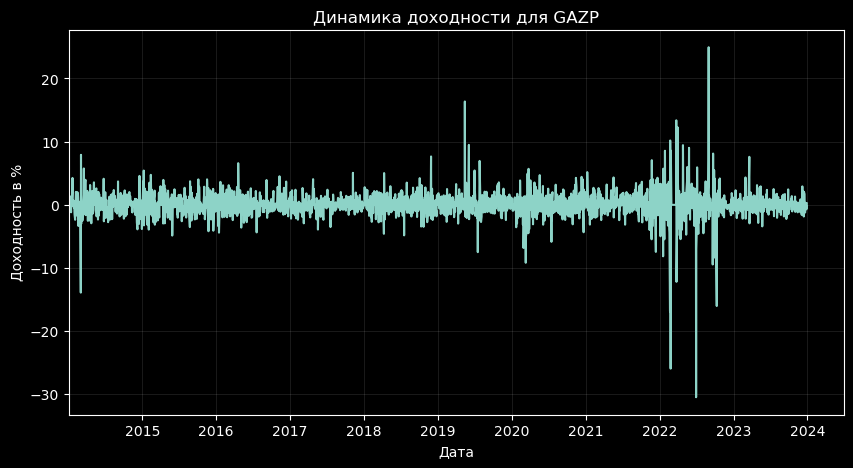

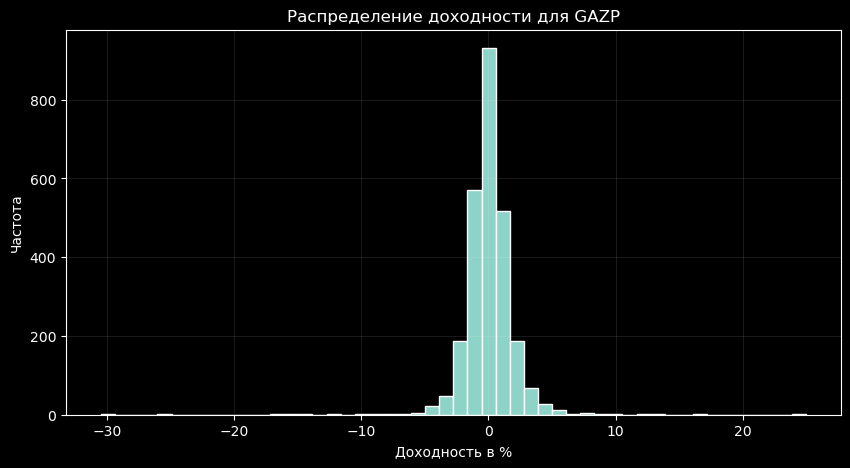

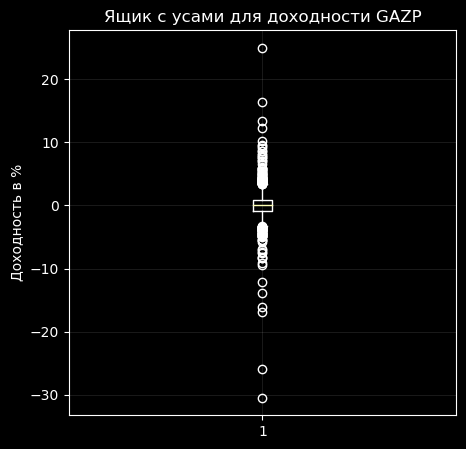

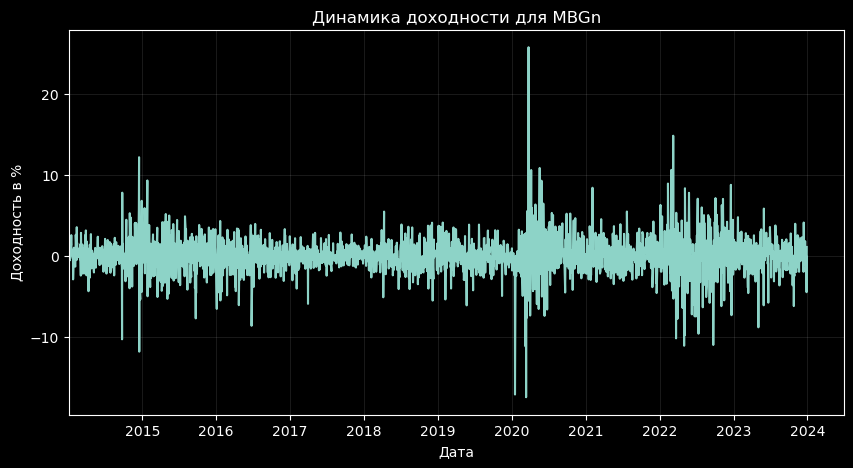

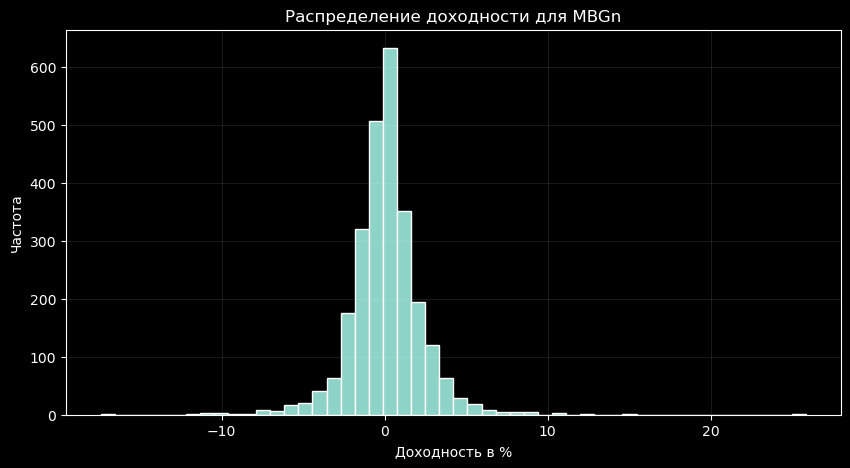

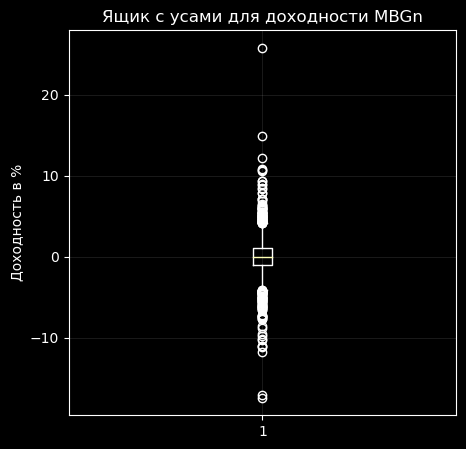

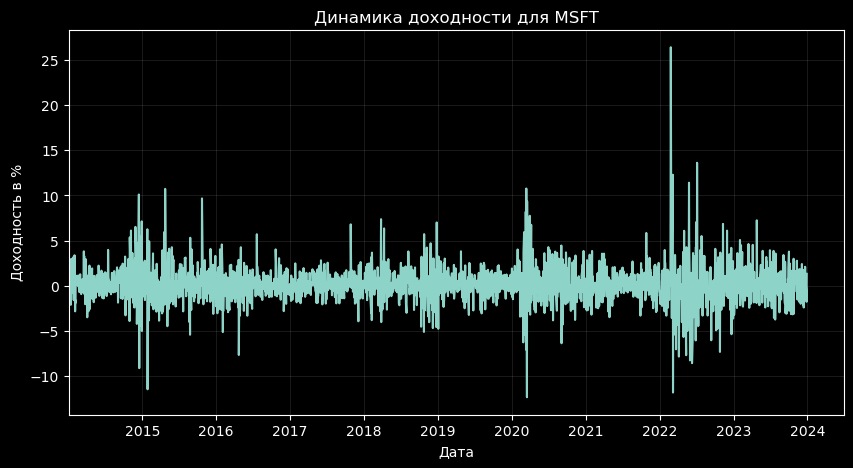

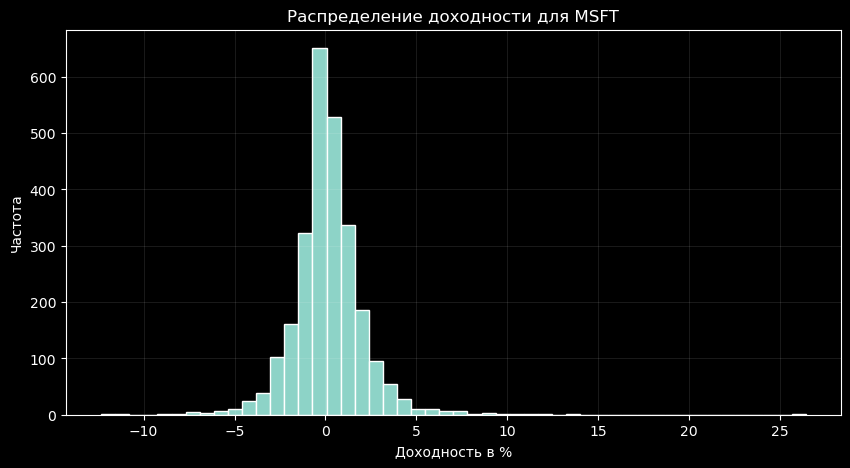

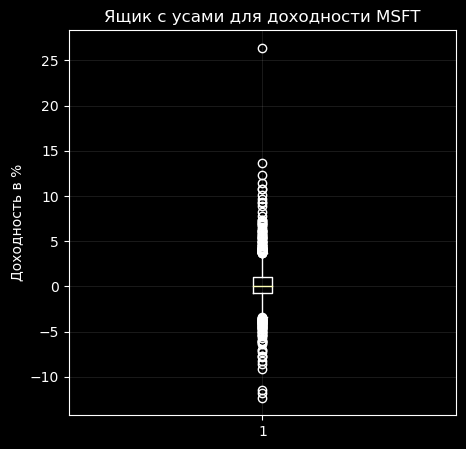

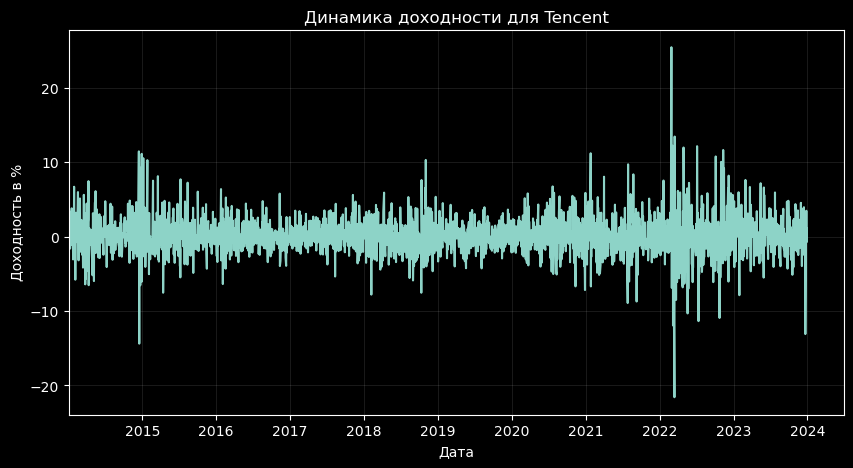

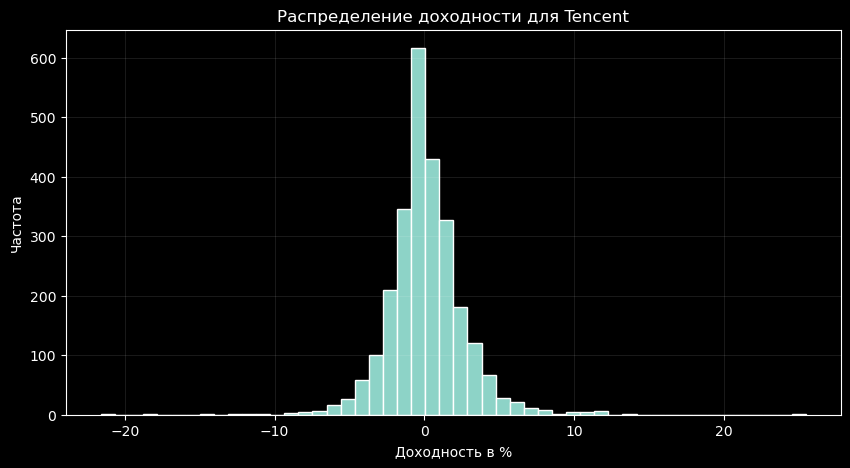

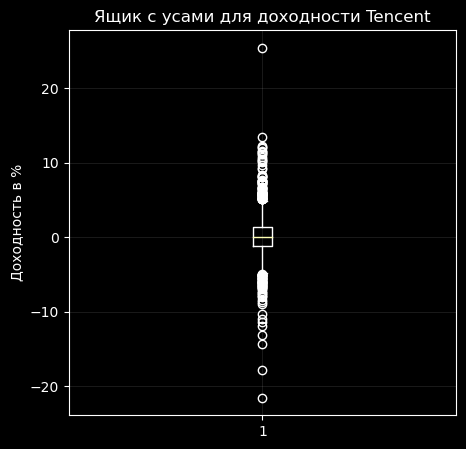

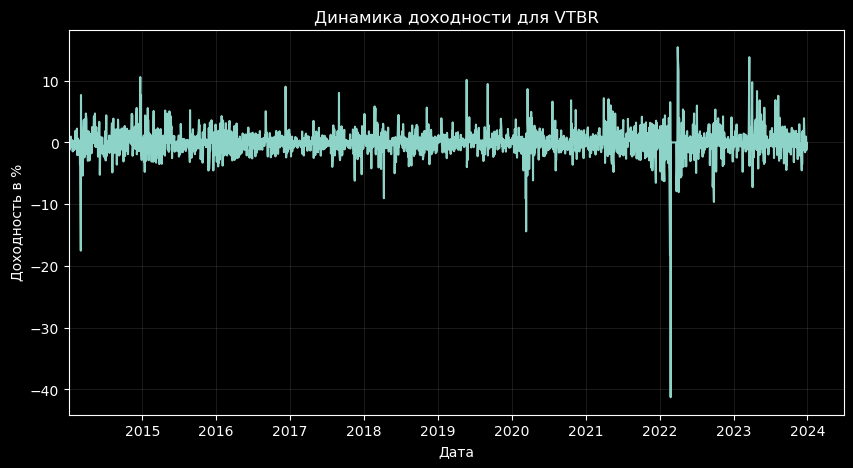

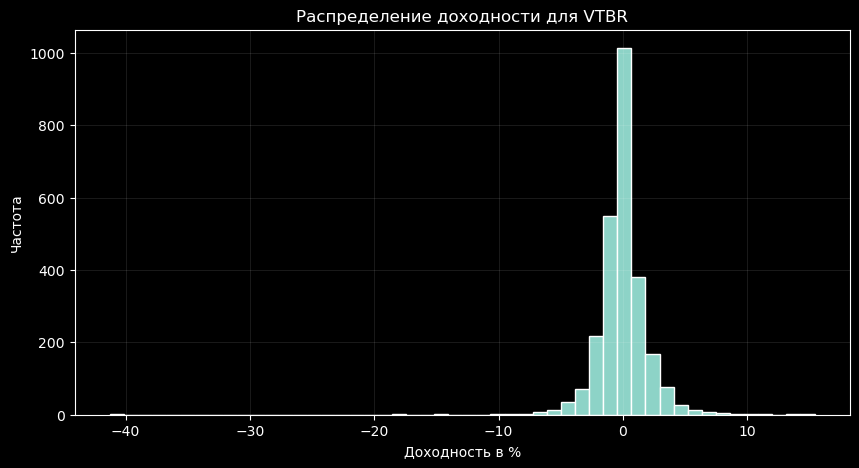

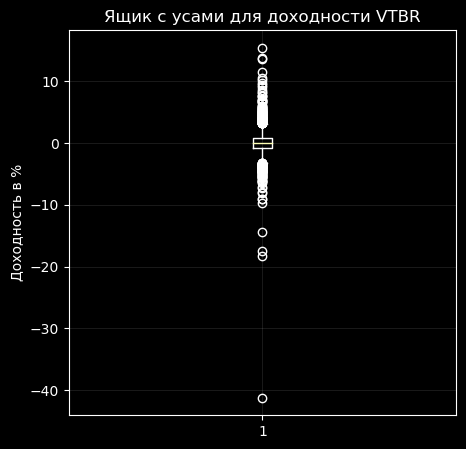

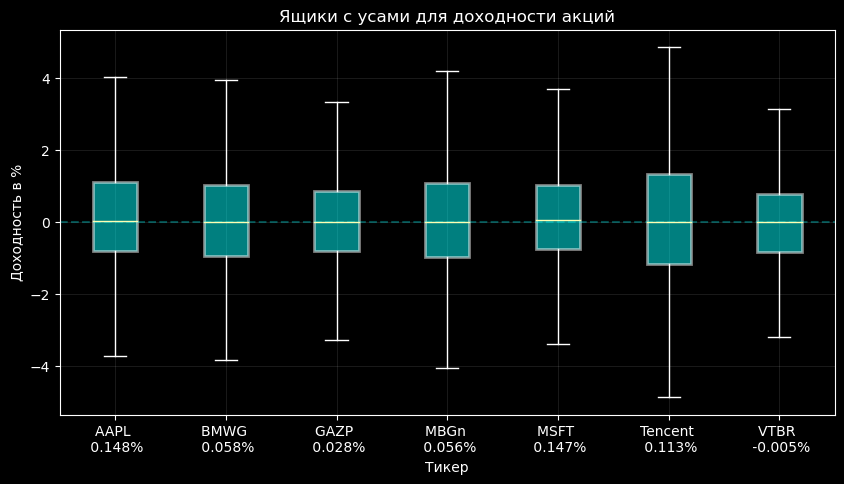

In [23]:
for ticker in df_pct_change.columns:
    plt.style.use('dark_background')
    plt.figure(figsize = (10, 5))
    plt.plot(df_pct_change[ticker])
    plt.xlim(df.index.min())
    plt.title(f'Динамика доходности для {ticker[5:]}')
    plt.xlabel('Дата')
    plt.ylabel('Доходность в %')
    plt.grid(True, alpha = 0.1)
    plt.show()
    
    plt.figure(figsize = (10, 5))
    plt.hist(df_pct_change[ticker].dropna(), bins = 50, edgecolor = "white")
    plt.title(f'Распределение доходности для {ticker[5:]}')
    plt.xlabel('Доходность в %')
    plt.ylabel('Частота')
    plt.grid(True, alpha = 0.1)
    plt.show()
    
    # если надо по отдельности для каждого тикера
    plt.figure(figsize=(5, 5))
    plt.boxplot(df_pct_change[ticker].dropna(), widths = 0.05)
    plt.title(f'Ящик с усами для доходности {ticker[5:]}')
    plt.ylabel('Доходность в %')
    plt.grid(True, alpha=0.1)
    plt.show()
    
plt.figure(figsize = (10, 5))

bp = plt.boxplot(df_pct_change.dropna(), widths = 0.4, showfliers = False, patch_artist = True)

for box in bp['boxes']:
    box.set(facecolor = 'cyan', alpha = 0.5)
    box.set(edgecolor = 'white', linewidth = 2)
    
label = [f'{ticker[5:]} \n {mean:.3f}%' for ticker, mean in zip(df_pct_change.columns, df_pct_change.mean())]
plt.xticks(ticks = range(1, len(label) + 1), labels = label)


plt.axhline(y = 0, color = 'cyan', linestyle = '--', alpha = 0.3)
plt.title('Ящики с усами для доходности акций')
plt.xlabel('Тикер')
plt.ylabel('Доходность в %')
plt.grid(True, alpha = 0.1)
plt.show()


__к) [5 баллов]__  В пункте __д)__ мы нашли даты, в которые наблюдались наибольшие измения стоимости ценых бумаг. При расчётах мы проигнорировали колебания курсов валют.

Давайте посмотрим, каким бы было колебание цен акций в абсолютном выражении для дат из таблички `top_5_diff`, если бы мы учли изменения курсов валют.

В таблице `df_pct_change` все доходности измерены в рублях. Посчитайте для этой таблицы построчное среднее для абсолютных значений изменений.

In [24]:
abs_df = df_pct_change.copy()
abs_df = abs_df.applymap(abs)
abs_df = abs_df.mean(axis=1)
abs_df = abs_df.reset_index().rename(columns={'index': 'Дата', 0: 'Изм. (RUB) %'})

abs_df

,Дата,Изм. (RUB) %
0,2014-01-02,NaN
1,2014-01-03,0.887044
2,2014-01-06,0.780805
3,2014-01-07,0.498447
4,2014-01-08,1.134081
...,...,...
2602,2023-12-25,0.224929
2603,2023-12-26,0.172522
2604,2023-12-27,0.924092
2605,2023-12-28,1.973598


Оставьте только те даты, которые встречаются в `top_5_diff`, и добавить их в качестве нового столбца `'Изм. (RUB) %'`

__Hint__: Чтобы выделить список необходимых дат из таблички `top_5_diff`, можно воспользоваться методом `to_list()` применительно к столбцу `'Дата'`. Такой список можно дальше использовать при обращении к строкам в `'[...]'`.

In [25]:
top_5_diff = top_5_diff.merge(abs_df[['Дата', 'Изм. (RUB) %']], on = 'Дата', how = 'left')


top_5_diff

,Дата,Изм. %,Изм. (RUB) %
0,2022-02-24,13.08,12.677837
1,2016-02-29,11.84,1.631587
2,2020-03-24,10.80,9.703503
3,2020-03-12,10.62,9.195150
4,2022-02-21,9.13,5.438385


__л) [2 балла]__  Проинтерпретируете уменьшение/увеличение процентного изменения стоимости акций при пересчете по курсу в рубли.

__Ответ:__ Все как-то очень неоднозначно, единственное что можно прокомментировать, так это 24 февраля, рост в рублях меньше из-за обесценения последнего 

## 3 Составляем портфель


Финансовые продукты описываются двумя характеристиками: __доходностью__ и __риском__.

Доходность — это процентное изменение стоимости за некоторый промежуток времени. Под риском, как правило, понимается стандартное отклонение доходности акций.

Однако когда речь идет о нескольких акциях в портфеле, то необходимо учитывать, как связана динамика цен на эти акции: падение доходности одной из акций может быть компенсировано ростом другой. Такой портфель будет предпочтительнее, поскольку предлагает меньшие риски для инвестора.

Осталось найти то самое сладкое сочетание активов... Для поиска оптимальных весов активов в портфеле обычно решается __задача оптимизации.__

Мы поступим проще:

- Будем рассматривать портфель, состоящий всего из 2 тикеров: `'AAPL'` и `'Tencent'`.
- Наилучшее сочетание весов будем искать неоптимальным способом, тупо перебирая различные варианты.

Пусть мы вкладываем долю нашего бюджета $w$ в первую ценную бумагу, а долю $(1 - w)$ во вторую. Тогда ожидаемая доходность порфеля составит

$$
\mathbb{E}(R) = w \cdot \mathbb{E}(R_1)  + (1 - w) \cdot \mathbb{E}(R_2).
$$

Дисперсия портфеля будет равна

$$
\text{Var}(R) = w^2 \cdot \text{Var}(R_1)  + (1 - w)^2 \cdot \text{Var}(R_2) + 2 \cdot w \cdot \text{Cov}(R_1, R_2).
$$

Ковариацию, по её определению, можно переписать как

$$
\text{Cov}(R_1, R_2) = \text{Corr}(R_1, R_2) \cdot \sigma(R_1) \cdot \sigma(R_2),
$$

где $\sigma(R_i) = \sqrt{ \text{Var}(R_i)}$.


Для начала создадим веса, которые будем рассматривать.

__а) [2 балла]__ С помощью функции `np.arange()` создайте `array` от $0$ до $1$ с шагом $0.01$ [(ссылка на документацию).](https://numpy.org/doc/stable/reference/generated/numpy.arange.html)

In [26]:
w = np.arange(0, 1.01, 0.01)
del df_pct_change['Цена BMWG']
del df_pct_change['Цена GAZP']
del df_pct_change['Цена MBGn']
del df_pct_change['Цена MSFT']
del df_pct_change['Цена VTBR']

w

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

Теперь запишем необходимые характеристики акций в соответствующие переменные:

__б) [3 балла]__ В переменные `r1` и `r2` сохраните среднюю доходность акций `'AAPL'` и `'Tencent'` из `df_pct_change`. Убедитесь, что доходности представлены не в процентах, а в виде чисел. Например не $10\%$, а $0.1$.

Кроме того, поскольку стандартной мерой доходности является годовая доходность, преобразуем среднюю ежедневную доходность в годовую, используя формулу сложного процента для полученных значений:

$$
r_{\text{год}} = (1 + r_{\text{день}})^{252} - 1,
$$

где:
- $r_{\text{год}}$ - ожидаемая годовая доходность,
- $r_{\text{день}}$ - средняя ежедневная доходность,
- $252$ - количество торговых дней в году (для большинства финансовых рынков).

In [27]:
df_pct_change['Цена AAPL'] = df_pct_change['Цена AAPL'] / 100
df_pct_change['Цена Tencent'] = df_pct_change['Цена Tencent'] / 100

r1_daily = df_pct_change['Цена AAPL'].mean()
r2_daily = df_pct_change['Цена Tencent'].mean()

r1 = (1 + r1_daily) ** 252 - 1
r2 = (1 + r2_daily) ** 252 - 1

r1, r2


(0.4498400845173225, 0.3295283131928597)

__в) [3 балла]__ Аналогично сохраните стандартные отклонения доходности этих акций в `sd1` и `sd2`. Преобразуйте эти значения из дневных в годовые:

$$
\sigma_{\text{год}} = \sigma_{\text{день}} \times \sqrt{252}
$$

Где:
- $\sigma_{\text{год}}$ - годовая волатильность,
- $\sigma_{\text{день}}$ - ежедневная волатильность,
- $252$ - количество торговых дней в году (для большинства финансовых рынков).

Эта формула основана на предположении, что ежедневные доходности распределены независимо и одинаково. В реальности рыночные условия могут влиять на точность этого преобразования, но это общепринятый метод для оценки годовой волатильности на основе ежедневных данных.

In [28]:
sd1_daily = df_pct_change['Цена AAPL'].std()
sd2_daily = df_pct_change['Цена Tencent'].std()

sd1 = sd1_daily * np.sqrt(252)
sd2 = sd2_daily * np.sqrt(252)
sd1, sd2

(0.33156058065998484, 0.4092074682339811)

__в) [1 балл]__ В переменную `rho` сохраните корреляцию между акциями.

In [29]:
rho = df_pct_change['Цена AAPL'].corr(df_pct_change['Цена Tencent'])
rho


0.26314132158240405

Теперь посчитаем доходность и волатильность портфеля, используя соответствующие формулы

In [30]:
r_p2 = w * r1 +(1 - w) * r2
sd_p2 = np.sqrt(w**2 * sd1**2 + (1 - w)**2 * sd2**2 + 2 * w * (1 - w) * rho * sd1 * sd2)

w

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

__г) [5 баллов]__ Постройте линейный график в осях (`sd_p2`, `r_p2`)

__Hint:__ Можно сделать с помощью `plt.plot(x, y)`

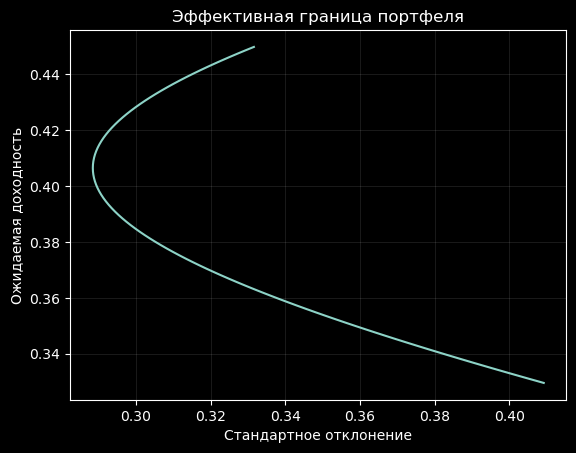

In [31]:
r_p2_array = []
sd_p2_array = []
for _ in w:
    r_p2_array.append(_ * r1 + (1 - _) * r2)
    sd_p2_array.append(np.sqrt(_**2 * sd1**2 + (1 - _)**2 * sd2**2 + 2 * _ * (1 - _) * rho * sd1 * sd2))

plt.plot(sd_p2_array, r_p2_array)
plt.xlabel('Стандартное отклонение')
plt.ylabel('Ожидаемая доходность')
plt.title('Эффективная граница портфеля')
plt.grid(True, alpha = 0.1)
plt.show()


Найдем портфель с минимальной дисперсией (риском).

__д) [3 балла]__ Для этого сначала создадим табличку со столбцами `'Вес'`, `'Риск'` и `'Доходность'` (содержащими `w`, `sd_p2` и `r_p2` соответственно)

In [32]:
data = {'Вес': w, 'Риск': sd_p2_array, 'Доходность': r_p2_array}
df_r = pd.DataFrame(data)

df_r

,Вес,Риск,Доходность
0,0.00,0.409207,0.329528
1,0.01,0.406000,0.330731
2,0.02,0.402819,0.331935
3,0.03,0.399664,0.333138
4,0.04,0.396536,0.334341
...,...,...,...
96,0.96,0.322992,0.445028
97,0.97,0.325060,0.446231
98,0.98,0.327178,0.447434
99,0.99,0.329345,0.448637


__е) [3 балла]__ Теперь найдем портфель с минимальным риском и запишем его в переменную `min_sd_p`, а само значение минимального риска в `min_sd`

In [33]:
min_sd_p = df_r.loc[df_r['Риск'].idxmin(), 'Вес']
min_sd = df_r.loc[df_r['Риск'].idxmin(), 'Риск']
min_r_p = df_r.loc[df_r['Риск'].idxmin(), 'Доходность']

print('w:', min_sd_p, '\nrisk:', min_sd, '\ndoxodnost:', min_r_p)


w: 0.64 
risk: 0.28841208268983215 
doxodnost: 0.4065278468405159


__ж) [3 балла]__ Выберем множество эффективных портфелей из `df_r`, тех, чья доходность и риск выше, чем у `min_sd_p` и сохраним их в `df_eff_p`

In [34]:
df_eff_p = df_r[(df_r['Доходность'] > min_r_p) & (df_r['Риск'] > min_sd)]

df_eff_p


,Вес,Риск,Доходность
65,0.65,0.288450,0.407731
66,0.66,0.288560,0.408934
67,0.67,0.288741,0.410137
68,0.68,0.288994,0.411340
69,0.69,0.289317,0.412543
70,0.70,0.289711,0.413747
71,0.71,0.290175,0.414950
72,0.72,0.290710,0.416153
73,0.73,0.291314,0.417356
74,0.74,0.291988,0.418559


__з) [3 балла]__ А теперь на основе `df_eff_p` построим эффективную границу, о которой шла речь раньше (часть кривой выше портфеля с наименьшей волатильностью)

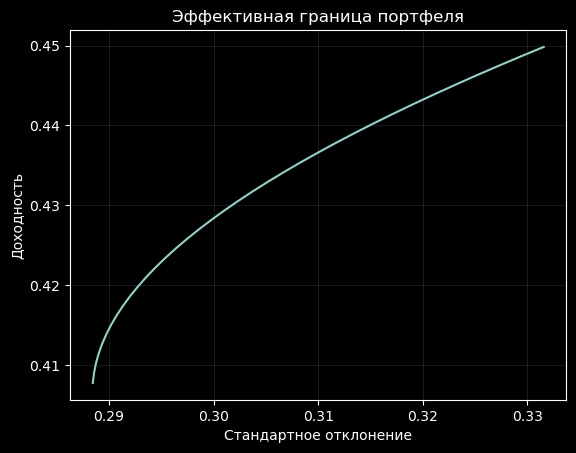

In [35]:
plt.plot(df_eff_p['Риск'], df_eff_p['Доходность'])
plt.title('Эффективная граница портфеля')
plt.xlabel('Стандартное отклонение')
plt.ylabel('Доходность')
plt.grid(True, alpha = 0.1)
plt.show()

В качестве безрисковой ставки доходности выберем доходность российских государственных облигаций сроком 10 лет (можно посмотреть [тут](https://cbr.ru/hd_base/zcyc_params/))

In [36]:
r_f = 11.8/100

__и) [3 балла]__ Теперь у нас есть возможность рассчитать коэффициент Шарпа для кадждого портфеля в `df_r`. Для этого необходимо вычесть из доходности портфеля безрисковую ставку (`r_f`) и разделить на волатильность (риск) портфеля. Сохраните полученные значения в столбец `'Sharp'` таблицы `df_r`

In [37]:
df_r['Sharp'] = (df_r['Доходность'] - r_f) / df_r['Риск']
df_r

,Вес,Риск,Доходность,Sharp
0,0.00,0.409207,0.329528,0.516922
1,0.01,0.406000,0.330731,0.523968
2,0.02,0.402819,0.331935,0.531093
3,0.03,0.399664,0.333138,0.538296
4,0.04,0.396536,0.334341,0.545577
...,...,...,...,...
96,0.96,0.322992,0.445028,1.012496
97,0.97,0.325060,0.446231,1.009754
98,0.98,0.327178,0.447434,1.006894
99,0.99,0.329345,0.448637,1.003922


__и) [3 балла]__ Определите портфель с максимальным коэффициентом Шарпа, сохраните его в переменную `max_sharp_p`, а значение самого коэффициента - в переменную `max_sharp`

In [38]:
max_sharp = df_r.loc[df_r['Sharp'].idxmax()]['Sharp']
max_sharp_p = df_r.loc[df_r['Sharp'].idxmax()]['Вес']
max_sharp, max_sharp_p

(1.0347718978386071, 0.81)

__к) [3 балла]__ В переменную `sigma` сохраните `numpy.array` с двумя перечисленными выше значениями

In [39]:
sigma = np.array([min_sd, df_r.loc[df_r['Sharp'].idxmax()]['Риск']])
sigma

array([0.28841208, 0.29859803])

__л) [3 балла]__ В переменную `r` сохраните значения доходности, находящиеся на указанной прямой, для значений риска из `sigma` (необходимо использовать формулу прямой)

In [40]:
r = max_sharp * sigma + r_f
r

array([0.41644072, 0.42698085])

__м) [5 баллов]__ Теперь построим эффективную границу, что мы уже делали ранее, и проведем указанную прямую (вернее ее часть).

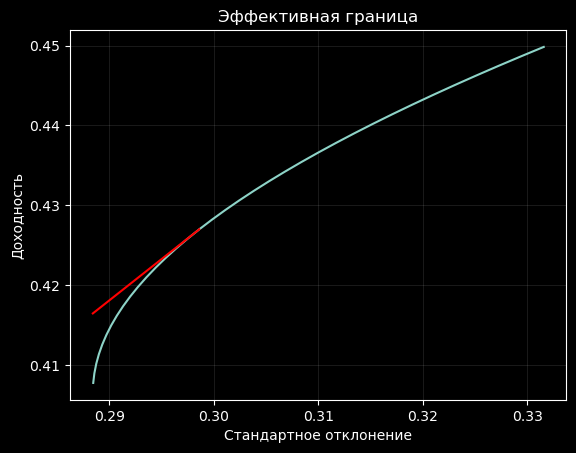

In [41]:
plt.plot(df_eff_p['Риск'], df_eff_p['Доходность'], markersize=4)
plt.plot(sigma, r, color='red')
plt.title('Эффективная граница')
plt.xlabel('Стандартное отклонение')
plt.ylabel('Доходность')
plt.grid(True, alpha = 0.1)
plt.show()

Полученная прямая является касательной к эффективной кривой, а точка ее касания представляет собой так называемый тангенциальный портфель.

Каждая точка на прямой Шарпа представляет собой портфель, состоящий из комбинации безрискового актива (в нашем случае, государственных облигаций) и рыночного портфеля (здесь, сочетание двух акций).

Все портфели на прямой Шарпа считаются эффективными в смысле оптимального соотношения риска и доходности. Это означает, что для любого данного уровня риска портфель на этой линии предоставляет максимально возможную доходность.

__н) [3 балла]__ Проинтерпретируйте численное значение наибольшего коэффициента Шарпа (`max_sharp`)

**Ответ:** Максимальное значение коэффициента Шарпа в нашем наборе портфелей- 1.03 означает, что конкретный портфель предлагает примерно 1% доп доходности за 1% дополнительного риска, то есть наш портфель дает доходность в два раз больше чем безрисковая бумага (ОФЗ/Трежери), но с двойным риском.

Таким образом, мы немного углубились в портфельную теорию и рассмотрели 2 основных метода оптимизации структуры портфеля:
- поиск наименее волатильного (рискового) портфеля
- поиск портфеля с оптимальным соотношением доходности и риска.